In [2]:
import pandas as pd
import numpy as np
import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geopandas as gpd
from shapely.geometry import Point

from scipy.interpolate import griddata

In [64]:
### Import file 1
gajhq_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GA  GAJHQ   Jabal al Hasir Data.xlsx"
#gajhq_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GA  GAJHQ   Jabal al Hasir Data.xlsx"
gajhq_raw_data = pd.read_excel(gajhq_filepath, sheet_name="Jabal al Hasir Database")

print("File imported successfully")

### Clean data

### Set custom headers, drop header rows, and reset index
gajhq_columns_part1 = gajhq_raw_data.iloc[6, 0:3].tolist()
gajhq_columns_part2 = gajhq_raw_data.iloc[4, 3:].tolist()

gajhq_columns = gajhq_columns_part1 + gajhq_columns_part2

print("Number of columns in part1:", len(gajhq_columns_part1))
print("columns1 =", gajhq_columns_part1)
print("Number of columns in part2:", len(gajhq_columns_part2))
print("columns2 =", gajhq_columns_part2)
print("Total columns in data:", gajhq_raw_data.shape[1])

gajhq_data = gajhq_raw_data.copy()
gajhq_data.columns = gajhq_columns
gajhq_data.columns = gajhq_data.columns.str.strip()
gajhq_data = gajhq_data.iloc[7:].reset_index(drop=True)


# Isolate DLs
gajhq_numerical_row = pd.to_numeric(gajhq_raw_data.iloc[5], errors="coerce").fillna(
    0
) + pd.to_numeric(gajhq_raw_data.iloc[6], errors="coerce").fillna(0)

gajhq_DLs = gajhq_numerical_row.to_numpy()
# print("GAJHQ DLs:", gajhq_DLs)

# Replace "<" values with 1/3 of the DL value
for col_index in range(3, gajhq_data.shape[1]):
    dl_value = gajhq_DLs[col_index]

    gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(
        r"<.*", 0.333333 * dl_value, regex=True
    )
    # print(f'replaced <DL values in column {col_index} with {dl_value * 0.333333}')


# Identify columns labeled as '%'
gajhq_labels = gajhq_raw_data.iloc[5].astype(str).fillna("") + gajhq_raw_data.iloc[
    6
].astype(str).fillna("")

gajhq_labels = gajhq_labels.str.strip()

percent_col_indices = gajhq_labels[gajhq_labels.str.contains("%", na=False)].index
percent_numerical_indices = [
    gajhq_raw_data.columns.get_loc(col) for col in percent_col_indices
]

# Convert % to ppm
gajhq_data.iloc[:, percent_numerical_indices] = (
    gajhq_data.iloc[:, percent_numerical_indices] * 10000
)

File imported successfully
Number of columns in part1: 3
columns1 = ['Sample No.', 'LONG', 'LAT']
Number of columns in part2: 56
columns2 = ['SiO2', 'Al2O3', 'Fe2O3', 'TiO2', 'CaO', 'MgO', 'Na2O', 'K2O', 'MnO', 'SO3', 'P2O5', 'LOI ', 'Au', 'Ag ', 'As ', 'Ba ', 'Be ', 'Bi ', 'Cd ', 'Ce ', 'Co ', 'Cr ', 'Cu ', 'Dy ', 'Er ', 'Eu', 'Ga', 'Gd', 'Ge ', 'Hf ', 'Ho', 'La ', 'Li ', 'Lu ', 'Mo ', 'Nb ', 'Nd ', 'Ni ', 'Pb ', 'Pr ', 'Sb ', 'Sc ', 'Sm ', 'Sn ', 'Sr ', 'Ta', 'Tb ', 'Th', 'Tm ', 'U ', 'V ', 'W', 'Y ', 'Yb ', 'Zn', 'Zr ']
Total columns in data: 59


C:\Users\TyHow\AppData\Local\Temp\ipykernel_41364\172702173.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(


In [65]:
### Import file 2
gsas_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GSAS_GM_094C_Quadrangle_Geochemical_Data.xlsx"
# gsas_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GSAS_GM_094C_Quadrangle_Geochemical_Data.xlsx"

gsas_raw_data = pd.read_excel(gsas_filepath, sheet_name="DS_RGP_GSAS_GM_094C")
print("File imported successfully")


### Clean data

### Set custom headers, drop header rows, and reset index
gsas_columns_part1 = gsas_raw_data.iloc[3, 0:5].tolist()
gsas_data = gsas_raw_data.copy()
gsas_columns = (
    gsas_columns_part1 + gsas_data.columns[len(gsas_columns_part1) :].tolist()
)
print("length of column names:", len(gsas_columns))

# Assign the new column names to the DataFrame
gsas_data.columns = gsas_columns
gsas_data.columns = gsas_data.columns.str.strip()  # Strip any whitespace
print("number of data columns:", len(gsas_data.columns))

# Drop header rows and reset index, drop analyte column
gsas_data = gsas_data.iloc[4:].reset_index(drop=True)
gsas_data = gsas_data.drop(gsas_data.columns[5], axis=1)

print("columns1 =", gsas_columns_part1)
print("Total columns in processed data:", gsas_data.shape[1])

# Identify column labels
gsas_labels = gsas_raw_data.iloc[2].astype(str).fillna("")  # Row with the units
gsas_labels = gsas_labels.str.strip()  # Remove leading/trailing whitespace
gsas_labels = gsas_labels.drop(gsas_labels.index[5])

# Iterate through all column labels and apply appropriate conversions
for col_index, unit in enumerate(gsas_labels):
    if unit == "%":
        # Convert % to ppm (multiply by 10000)
        gsas_data.iloc[:, col_index] = (
            gsas_data.iloc[:, col_index].astype(float) * 10000
        )
        #print(f"Converted column {gsas_data.columns[col_index]} from % to ppm.")
    elif unit == "ng/g":
        # Convert ng/g to ppm 
        gsas_data.iloc[:, col_index] = gsas_data.iloc[:, col_index].astype(float) / 1000
        #print(f"Converted column {gsas_data.columns[col_index]} from ng/g to ppm.")
    elif unit == "mg/kg":
        pass
        # mg/kg is equivalent to ppm, no conversion needed
        #print(
        #    f"Column {gsas_data.columns[col_index]} is already in ppm (mg/kg). No conversion applied."
        #)
    else:
        pass
        # Handle columns with no recognized unit or no conversion needed
        #print(
        #    f"Column {gsas_data.columns[col_index]} has unrecognized or no unit. Skipped conversion."
        #)

# Print a summary of the updated columns
print("Unit conversion completed.")

# Convert all data columns to numeric data type
for col in gsas_data.columns[3:]:
    gsas_data[col] = pd.to_numeric(gsas_data[col], errors="coerce")
print("Converted all columns from column 3 onward to numeric data type.")


File imported successfully
length of column names: 63
number of data columns: 63
columns1 = ['Sample Field Number', 'Smaple Code', 'Lab Sample Number', 'Longitude', 'Latitude']
Total columns in processed data: 62
Unit conversion completed.
Converted all columns from column 3 onward to numeric data type.


In [71]:
print('gajhq columns:', gajhq_data.columns)
print(len(gajhq_data.columns))
print('gsas columns:', gsas_data.columns)
print(len(gsas_data.columns))

gajhq columns: Index(['sample_id', 'long', 'lat', 'sio2', 'al2o3', 'fe2o3', 'tio2', 'cao',
       'mgo', 'na2o', 'k2o', 'mno', 'so3', 'p2o5', 'loi', 'au', 'ag', 'as',
       'ba', 'be', 'bi', 'cd', 'ce', 'co', 'cr', 'cu', 'dy', 'er', 'eu', 'ga',
       'gd', 'ge', 'hf', 'ho', 'la', 'li', 'lu', 'mo', 'nb', 'nd', 'ni', 'pb',
       'pr', 'sb', 'sc', 'sm', 'sn', 'sr', 'ta', 'tb', 'th', 'tm', 'u', 'v',
       'w', 'y', 'yb', 'zn', 'zr'],
      dtype='object')
59
gsas columns: Index(['sample_id', 'smaple_code', 'lab_sample_number', 'long', 'lat', 'br',
       'cl', 'cr', 'hf', 'p', 'rb', 'ti', 'zr', 'sio2', 'al2o3', 'tfe2o3',
       'k2o', 'ba', 'mn', 'sr', 'v', 'zn', 'mgo', 'cao', 'na2o', 'be', 'bi',
       'co', 'cs', 'cu', 'ga', 'in', 'li', 'mo', 'nb', 'ni', 'tl', 'te', 'sc',
       'y', 'ge', 'i', 'ta', 'w', 're', 'au', 'ir', 'os', 'pd', 'pt', 'rh',
       'ru', 'sb', 'se', 'ag', 'b', 'sn', 'f', 'n', 's', 'tc', 'loi'],
      dtype='object')
62


In [72]:
gsas_elements = gsas_data.columns[5:]  # Assuming the first three columns are metadata
gajhq_elements = gajhq_data.columns[3:]

common_elements = set(gsas_elements).intersection(set(gajhq_elements))
gsas_only = set(gsas_elements) - common_elements
gajhq_only = set(gajhq_elements) - common_elements

print(len(common_elements), "Common elements:", common_elements)
print(len(gsas_only), "Elements only in GSAS:", gsas_only)
print(len(gajhq_only), "Elements only in GAJHQ:", gajhq_only)

gsas_data.columns = gsas_data.columns.str.lower().str.strip().str.replace(" ", "_")
gajhq_data.columns = gajhq_data.columns.str.lower().str.strip().str.replace(" ", "_")
#gsas_data.columns = gsas_data.columns.str.strip().str.replace(" ", "_")
#gajhq_data.columns = gajhq_data.columns.str.strip().str.replace(" ", "_")

print("GSAS columns:", gsas_data.columns.tolist())
print("GAJHQ columns:", gajhq_data.columns.tolist())

gsas_data = gsas_data.rename(
    columns={"sample_field_number": "sample_id", "longitude": "long", "latitude": "lat"}
)

gajhq_data = gajhq_data.rename(
    columns={"sample_no.": "sample_id", "long": "long", "lat": "lat"}
)

gsas_elements = gsas_data.columns[5:]  # Adjust as needed
gajhq_elements = gajhq_data.columns[3:]

common_elements = set(gsas_elements).intersection(set(gajhq_elements))

# Find elements present in both datasets
gsas_common = [col for col in common_elements if col in gsas_data.columns]
gajhq_common = [col for col in common_elements if col in gajhq_data.columns]

# Ensure alignment
aligned_common = list(set(gsas_common).intersection(set(gajhq_common)))

32 Common elements: {'be', 'bi', 'sio2', 'cao', 'au', 'hf', 'zr', 'ni', 'k2o', 'ag', 'y', 'mgo', 'cr', 'sc', 'co', 'nb', 'li', 'ba', 'ta', 'v', 'mo', 'na2o', 'w', 'zn', 'cu', 'ge', 'loi', 'al2o3', 'sr', 'sb', 'sn', 'ga'}
25 Elements only in GSAS: {'ti', 'ir', 'tc', 'mn', 'ru', 'tfe2o3', 'i', 'in', 'cl', 'br', 'cs', 'te', 'n', 'f', 'tl', 'pt', 'pd', 're', 'se', 'p', 'rb', 'rh', 's', 'os', 'b'}
24 Elements only in GAJHQ: {'fe2o3', 'tm', 'sm', 'ho', 'tb', 'so3', 'la', 'nd', 'th', 'pb', 'p2o5', 'u', 'yb', 'as', 'gd', 'cd', 'mno', 'tio2', 'pr', 'dy', 'ce', 'er', 'eu', 'lu'}
GSAS columns: ['sample_id', 'smaple_code', 'lab_sample_number', 'long', 'lat', 'br', 'cl', 'cr', 'hf', 'p', 'rb', 'ti', 'zr', 'sio2', 'al2o3', 'tfe2o3', 'k2o', 'ba', 'mn', 'sr', 'v', 'zn', 'mgo', 'cao', 'na2o', 'be', 'bi', 'co', 'cs', 'cu', 'ga', 'in', 'li', 'mo', 'nb', 'ni', 'tl', 'te', 'sc', 'y', 'ge', 'i', 'ta', 'w', 're', 'au', 'ir', 'os', 'pd', 'pt', 'rh', 'ru', 'sb', 'se', 'ag', 'b', 'sn', 'f', 'n', 's', 'tc', 'loi

In [73]:
# Include metadata columns
metadata_cols = ["sample_id", "long", "lat"]

# Subset datasets
gsas_subset = gsas_data[metadata_cols + aligned_common]
gajhq_subset = gajhq_data[metadata_cols + aligned_common]

gsas_unique = gsas_data[["sample_id"] + list(gsas_only)]
gajhq_unique = gajhq_data[["sample_id"] + list(gajhq_only)]

# Merge datasets
merged_data = pd.merge(
    gsas_subset,
    gajhq_subset,
    on=metadata_cols,
    how="outer",
    suffixes=("_gsas", "_gajhq"),
)

# Add back unique columns
merged_data = merged_data.merge(gsas_unique, on="sample_id", how="left")
merged_data = merged_data.merge(gajhq_unique, on="sample_id", how="left")


merged_data = merged_data.fillna(0)

for col in common_elements:
    merged_data[col] = merged_data[f"{col}_gsas"].combine_first(
        merged_data[f"{col}_gajhq"]
    )
    merged_data.drop(columns=[f"{col}_gsas", f"{col}_gajhq"], inplace=True)

C:\Users\TyHow\AppData\Local\Temp\ipykernel_41364\2593338481.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data = merged_data.fillna(0)


In [74]:
print("Merged dataset shape:", merged_data.shape)
print(merged_data.columns)
merged_data

Merged dataset shape: (3339, 84)
Index(['sample_id', 'long', 'lat', 'ti', 'ir', 'tc', 'mn', 'ru', 'tfe2o3', 'i',
       'in', 'cl', 'br', 'cs', 'te', 'n', 'f', 'tl', 'pt', 'pd', 're', 'se',
       'p', 'rb', 'rh', 's', 'os', 'b', 'fe2o3', 'tm', 'sm', 'ho', 'tb', 'so3',
       'la', 'nd', 'th', 'pb', 'p2o5', 'u', 'yb', 'as', 'gd', 'cd', 'mno',
       'tio2', 'pr', 'dy', 'ce', 'er', 'eu', 'lu', 'be', 'bi', 'sio2', 'cao',
       'au', 'hf', 'zr', 'ni', 'k2o', 'ag', 'y', 'mgo', 'cr', 'sc', 'co', 'nb',
       'li', 'ba', 'ta', 'v', 'mo', 'na2o', 'w', 'zn', 'cu', 'ge', 'loi',
       'al2o3', 'sr', 'sb', 'sn', 'ga'],
      dtype='object')


,sample_id,long,lat,ti,ir,tc,mn,ru,tfe2o3,i,...,w,zn,cu,ge,loi,al2o3,sr,sb,sn,ga
0,421911AD001,42.772083,19.993880,3307.385,0.000030,6725.0,558.2,0.000049,42186.0,1.879749,...,0.907406,52.39,18.20628,0.972045,38100.0,158536.0,627.7,0.4220,1.402524,22.19062
1,421911AD002,42.778492,19.996819,4517.659,0.000028,4647.0,699.4,0.000038,58877.0,1.107642,...,0.608237,76.03,18.54008,1.226041,35300.0,133917.0,275.0,0.8238,1.902777,18.78819
2,421911AD003,42.814612,19.982057,5789.542,0.000032,6186.0,915.9,0.000052,73709.0,1.119658,...,0.694675,90.50,21.09416,1.472250,39100.0,136386.0,265.9,1.2301,2.071384,20.31448
3,421911AD004,42.837565,19.998416,5571.547,0.000035,4283.0,931.9,0.000056,69539.0,1.080863,...,0.881454,84.01,19.20453,1.441504,36800.0,140112.0,292.0,1.3016,2.109990,20.44046
4,421911AD005,42.857754,20.000042,3563.759,0.000028,10348.0,978.4,0.000066,75211.0,1.609668,...,0.501730,85.76,45.95883,1.179303,62600.0,132591.0,225.2,1.2758,1.064029,15.55654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,GAJHQ-948,42.047120,19.876410,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.00000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.00000
3335,GAJHQ-949,42.049270,19.911280,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.00000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.00000
3336,GAJHQ-950,42.077210,19.974210,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.00000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.00000
3337,GAJHQ-951,42.150070,19.979850,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.00000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.00000


In [75]:
# Create a mapping for elements to oxides (or vice versa)
combine_mapping = {"tio2": "ti", "fe2o3": "tfe2o3", "p2o5": "p", "mno": "mn"}

# Conversion factors (oxide -> element)
conversion_factors = {
    "tio2": 47.867 / 79.866,  # Ti molar mass / TiO2 molar mass
    "fe2o3": 55.845 / 159.69,  # Fe molar mass / Fe2O3 molar mass
    "p2o5": 30.974 / 141.944,  # P molar mass / P2O5 molar mass
    "mno": 54.938 / 70.937,  # Mn molar mass / MnO molar mass
}

# Loop through the mapping to combine columns
for oxide, element in combine_mapping.items():
    if oxide in merged_data.columns and element in merged_data.columns:
        # Convert oxide to element units and add to the element column
        merged_data[element] = merged_data[element].fillna(0) + (
            merged_data[oxide] * conversion_factors[oxide]
        ).fillna(0)

        # Drop the oxide column after merging
        merged_data.drop(columns=[oxide], inplace=True)
    elif oxide in merged_data.columns:
        # If only the oxide exists, rename it to the element
        merged_data[element] = merged_data[oxide] * conversion_factors[oxide]
        merged_data.drop(columns=[oxide], inplace=True)

Statistics:

Average correlation: 0.07878468561908637
Max correlation: 1.0
Min correlation: -0.969397457629558


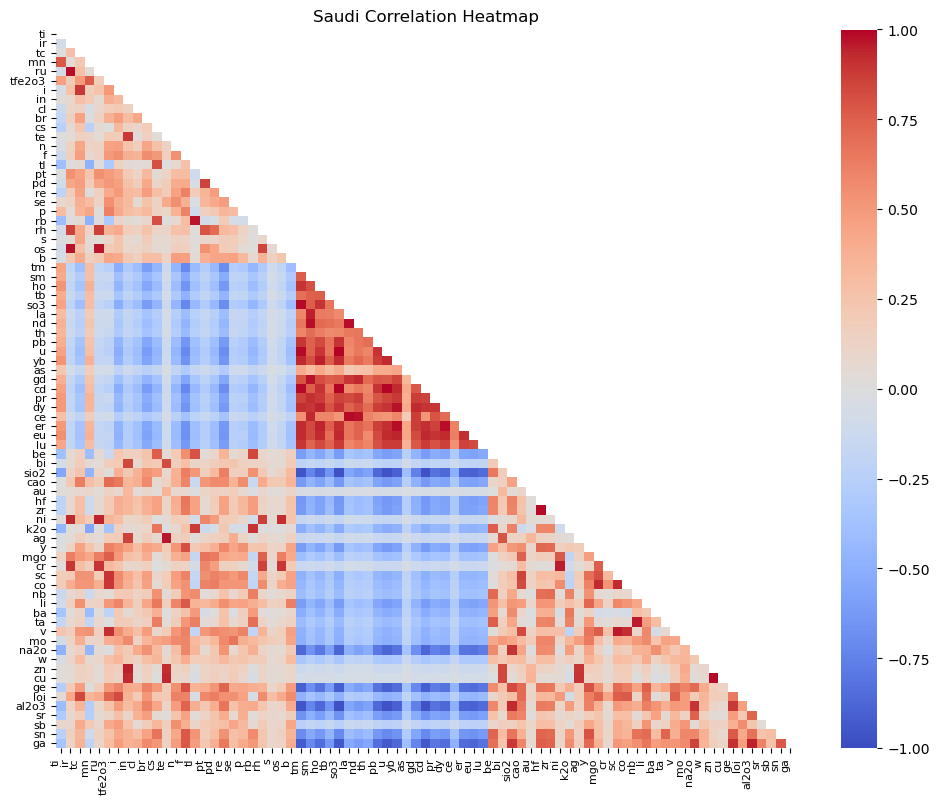

In [76]:
# Corr plot
corr = merged_data.iloc[:, 3:].corr()

print("Statistics:\n")
print("Average correlation:", corr.stack().mean())
print("Max correlation:", corr.stack().max())
print("Min correlation:", corr.stack().min())

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

# Explicitly set tick positions and labels
tick_positions = np.arange(0.5, len(corr))
plt.xticks(
    ticks=tick_positions,
    labels=corr.columns,
    rotation=90,
    fontsize=8,
    ha="right",
)
plt.yticks(
    ticks=tick_positions,
    labels=corr.index,
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.title("Saudi Correlation Heatmap")
plt.show()

Blocks from top to bottom: 
- GSAS
- GAJHQ
- Common

In [77]:
### PCA

# Omit non-numeric columns
data_pca = gsas_data.copy()
data_pca = data_pca.iloc[:, 3:]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(data_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
# print("Explained Variance Ratios:", gsas_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    pca_results, columns=[f"PC{i+1}" for i in range(len(explained_variance))]
)

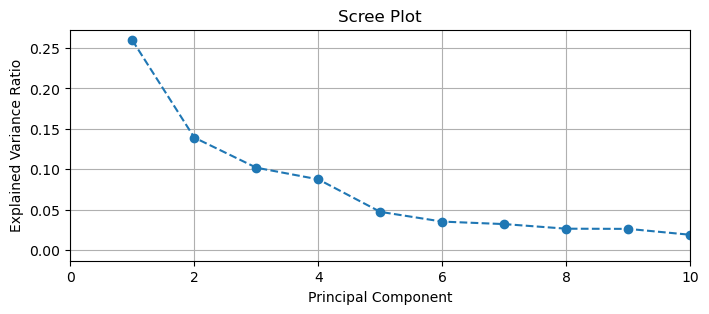

In [78]:
# Plot PCA scree plot
plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xlim(0, 10)
plt.grid()
plt.show()

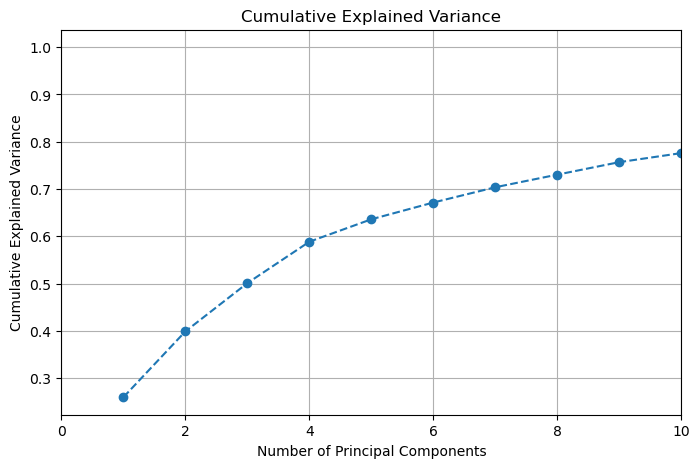

In [79]:
# Culmulative explained variance
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.xlim(0, 10)
plt.grid()
plt.show()

PC1: ['tfe2o3', 'co', 'sio2', 'sc', 'mn']
PC2: ['nb', 'ta', 'sn', 'zr', 'hf']
PC3: ['ru', 'ir', 'os', 'cr', 'ni']
PC4: ['cu', 'te', 'zn', 'ag', 'bi']


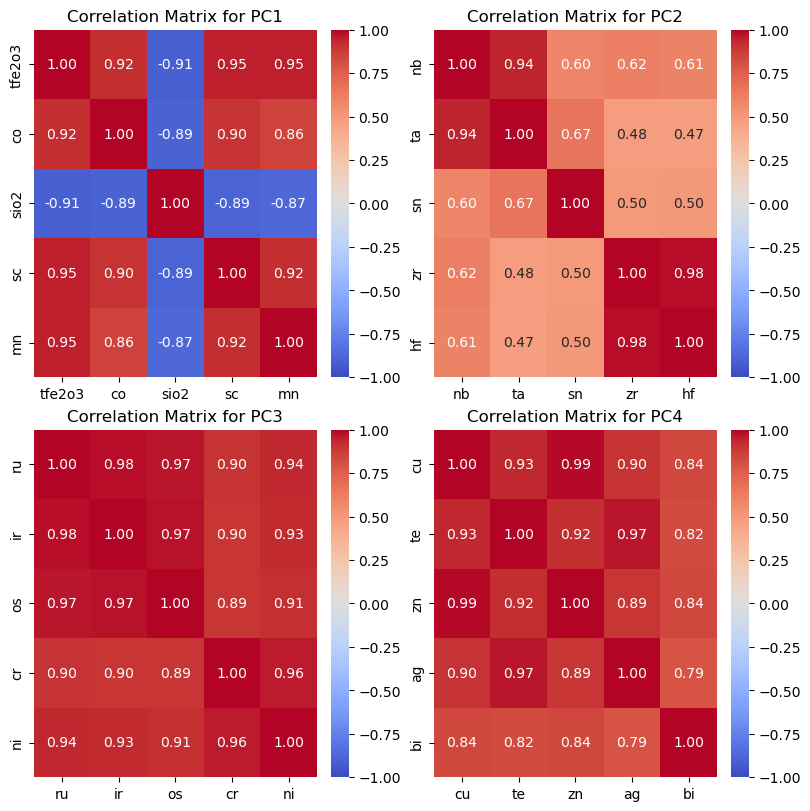

In [80]:
### Extract top features per PC

# Set parameters
num_pcs = 4  # Number of PCs to analyze
top_features_per_pc = 5  # Number of top features to extract per PC

# Prepare lists for groups of features
groups = {}

# Iterate through each PC and extract top features
for pc_index in range(num_pcs):
    # Extract feature contributions for the current PC
    contributions = pd.DataFrame(
        {
            "Feature": data_pca.columns,
            f"PC{pc_index + 1} Contribution": np.abs(pca.components_[pc_index]),
        }
    )
    # Sort by contribution and select top features
    top_features = contributions.nlargest(
        top_features_per_pc, f"PC{pc_index + 1} Contribution"
    )["Feature"].tolist()
    groups[f"PC{pc_index + 1}"] = top_features

# Display groups of correlated features
for pc, features in groups.items():
    print(f"{pc}: {features}")


## Plot

# Number of PC groups
num_groups = len(groups)

# Calculate rows and columns for square-like layout
cols = math.ceil(math.sqrt(num_groups))
rows = math.ceil(num_groups / cols)

# Create a grid of subplots
fig, axes = plt.subplots(
    rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True
)

# Flatten the axes array for easy iteration (handles cases where rows > 1)
axes = axes.flatten()

# Iterate through the groups and plot each correlation matrix on a subplot
for idx, (pc, features) in enumerate(groups.items()):
    corr_matrix = data_pca[features].corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        ax=axes[idx],
    )
    axes[idx].set_title(f"Correlation Matrix for {pc}")

# Hide any unused subplots
for ax in axes[num_groups:]:
    ax.axis("off")

# Show the final plot with all subplots
plt.show()